In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [6]:
# IMAGES_PATH = "./data/train2017/train2017"  # Directory with training images
# VAL_IMAGES_PATH = "./data/val2017/val2017"  # Directory with validation images
# CAPTIONS_PATH = "./data/annotations_trainval2017/annotations/captions_train2017.json"  # Caption file
# VAL_CAPTIONS_PATH = "./data/annotations_trainval2017/annotations/captions_val2017.json"  # Validation caption file

IMAGES_PATH = "../phase_1/data/flickr8k/images"  # Directory with training images
CAPTIONS_PATH = "../phase_1/data/flickr8k/captions.txt"  # Caption file
TEST_IMAGES_PATH = "../phase_1/test copy/"  # Directory with test images

In [3]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [7]:
import tqdm
import nltk 
from collections import Counter
from phase_2_flikr.vocabulary_class import Vocabulary
nltk.download('punkt_tab')
import json

tokens = []
counter = Counter()

import csv

def build_vocab(json_path, threshold=5, limit=None):
    
    counter = Counter()
    image_captions = {}
    count =0
    with open(CAPTIONS_PATH, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader)  # skip header: image,caption

        for row in reader:
            if len(row) < 2:
                continue
            img_name, caption = row
            if img_name not in image_captions:
                    image_captions[img_name] = []
            image_captions[img_name].append(caption)

            caption = caption.lower()
            tokens = nltk.tokenize.word_tokenize(caption)
            counter.update(tokens)
            count +=1
            if limit and count >= limit:
                break
    
    vocab = Vocabulary()
    for word, cnt in counter.items():
        if cnt >= threshold:
            vocab.add_word(word)
    
    return vocab, image_captions

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
vocab, image_captions = build_vocab(CAPTIONS_PATH, threshold=5)
print("Total vocabulary size:", len(vocab))

Total vocabulary size: 3005


In [21]:
len(image_captions)

8091

In [9]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [10]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    images, captions = zip(*batch)

    images = torch.stack(images, 0)

    lengths = torch.tensor([len(c) for c in captions])

    captions = pad_sequence(
        captions,
        batch_first=True,
        padding_value=0
    )

    return images, captions, lengths

In [11]:
from torch.utils.data import DataLoader
from phase_2_flikr.flickr_dataset import FlickrDataset 

train_dataset = FlickrDataset(
    root=IMAGES_PATH,
    captions_path=CAPTIONS_PATH,
    vocab=vocab,
    transform=transform,
    max_samples=None
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn= collate_fn
)



In [12]:
print(len(train_dataset))

8091


In [13]:
image, caption = train_dataset[0]

print(type(image))
print(image.shape)        # after transform
print(caption)
print(len(caption))

<class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([ 1,  3, 18, 19, 20,  4, 21, 22, 17,  2])
10


In [27]:
from phase_2_flikr.model import EncoderViT, DecoderRNN
import torch.nn as nn

encoder = EncoderViT(embed_size=256).to(device)
decoder = DecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<pad>"])

params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)
train_losses = []

In [28]:

for epoch in range(15):
    total_train_loss = 0
    for images, captions, lengths in tqdm.tqdm(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        
        features = encoder(images)
        outputs = decoder(features, captions, lengths)   # <-- IMPORTANT
        targets = captions[:, 1:]                       # shift left
        outputs = outputs[:, :-1, :]                    # align prediction
        loss = criterion(outputs.reshape(-1, len(vocab)),
                            targets.reshape(-1))

        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch}: Train={avg_train_loss:.4f}")

100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 0: Train=4.4431


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 1: Train=3.9913


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 2: Train=3.8465


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 3: Train=3.7526


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 4: Train=3.6751


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 5: Train=3.6113


100%|██████████| 253/253 [01:28<00:00,  2.84it/s]


Epoch 6: Train=3.5736


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 7: Train=3.5123


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 8: Train=3.4663


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 9: Train=3.4493


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 10: Train=3.4029


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 11: Train=3.3529


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 12: Train=3.3100


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]


Epoch 13: Train=3.2748


100%|██████████| 253/253 [01:29<00:00,  2.84it/s]

Epoch 14: Train=3.2453


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def find_elbow_epoch(losses):
    losses = np.array(losses)

    # First & second derivative
    first_derivative = np.diff(losses)
    second_derivative = np.diff(first_derivative)

    # Elbow = point of max curvature
    elbow_epoch = np.argmax(np.abs(second_derivative)) + 2
    return elbow_epoch

def plot_elbow(losses, elbow_epoch, title):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, losses, marker='o', label='Validation Loss')
    plt.axvline(elbow_epoch, linestyle='--', color='red',
                label=f'Elbow Epoch = {elbow_epoch}')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

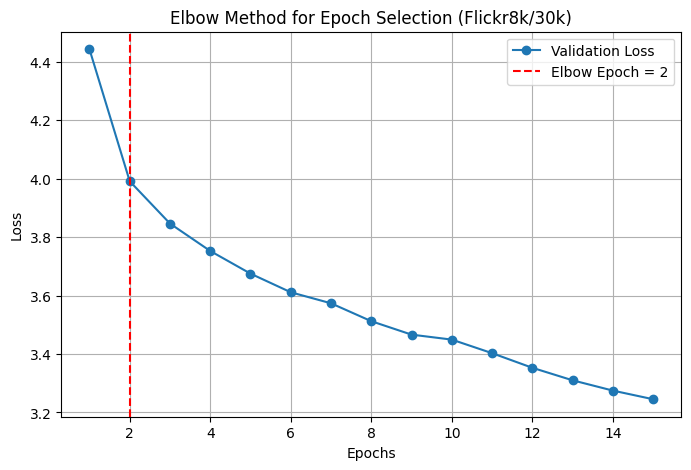

In [30]:
elbow_epoch = find_elbow_epoch(train_losses)
plot_elbow(
    train_losses,
    elbow_epoch,
    title="Elbow Method for Epoch Selection (Flickr8k/30k)"
)

In [31]:
def generate_caption(image, encoder, decoder, vocab):
    encoder.eval()
    decoder.eval()
    image = image.unsqueeze(0).to(device)
    feature = encoder(image)              # [1, 256]
    feature = feature.unsqueeze(1)        # [1, 1, 256]

    # 2. Start sequence with <start> token
    start_token = vocab.word2idx["<start>"]
    end_token = vocab.word2idx["<end>"]

    sampled_ids = []
    inputs = torch.LongTensor([[start_token]]).to(image.device)

    # 3. FIRST STEP: concatenate image feature + embedding(<start>)
    embeddings = decoder.embed(inputs)     # [1,1,256]
    lstm_input = torch.cat((feature, embeddings), dim=1)  # [1,2,256]

    hiddens, states = decoder.lstm(lstm_input)

    outputs = decoder.linear(hiddens[:, -1, :])
    predicted = outputs.argmax(dim=1).item()
    sampled_ids.append(predicted)

    # 4. NEXT STEPS: only feed predicted tokens (NO concatenation!)
    inputs = torch.LongTensor([[predicted]]).to(image.device)

    for _ in range(20):
        embeddings = decoder.embed(inputs)  # [1,1,256]

        hiddens, states = decoder.lstm(embeddings, states)
        outputs = decoder.linear(hiddens[:, -1, :])
        
        predicted = outputs.argmax(dim=1).item()
        sampled_ids.append(predicted)
        
        if predicted == end_token:
            break

        inputs = torch.LongTensor([[predicted]]).to(image.device)

    words = [vocab.idx2word[id] for id in sampled_ids]
    return " ".join(words)

In [32]:
# torch.save({
#     'encoder_state_dict': encoder.state_dict(),
#     'decoder_state_dict': decoder.state_dict(),
#     'vocab': vocab,
#     'embed_size': 256,
#     'hidden_size': 512
# }, 'model.pth')

torch.save(encoder.state_dict(), "models/encoder.pth")
torch.save(decoder.state_dict(), "models/decoder.pth")
torch.save(vocab, "models/vocab.pkl")

In [15]:
from phase_2_flikr.vocabulary_class import Vocabulary
from phase_2_flikr.model import EncoderViT, DecoderRNN
import torch

vocab = torch.load("models/vocab.pkl", weights_only=False)
encoder = EncoderViT(256).to(device)
decoder = DecoderRNN(
    256,
    512,
    len(vocab)
).to(device)

encoder.load_state_dict(torch.load("models/encoder.pth", weights_only=True, map_location=device))
decoder.load_state_dict(torch.load("models/decoder.pth", weights_only=True, map_location=device))

RuntimeError: Error(s) in loading state_dict for EncoderViT:
	size mismatch for vit.pos_embed: copying a param with shape torch.Size([1, 197, 768]) from checkpoint, the shape in current model is torch.Size([1, 50, 768]).
	size mismatch for vit.patch_embed.proj.weight: copying a param with shape torch.Size([768, 3, 16, 16]) from checkpoint, the shape in current model is torch.Size([768, 3, 32, 32]).

In [34]:
from rouge_score import rouge_scorer

def tokens_to_string(tokens):
    if isinstance(tokens, list):
        return " ".join(tokens)
    return tokens

def compute_rouge_l(references, hypotheses):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    scores = []

    for refs, hyp in zip(references, hypotheses):
        hyp_str = tokens_to_string(hyp)

        rouge_l_scores = []
        for ref in refs:
            ref_str = tokens_to_string(ref)
            score = scorer.score(ref_str, hyp_str)['rougeL'].fmeasure
            rouge_l_scores.append(score)

        scores.append(max(rouge_l_scores))  # best reference

    return sum(scores) / len(scores)

from jiwer import wer
def compute_wer(references, hypotheses):
    """
    Computes WER using best matching reference per hypothesis
    """
    wers = []
    ref_tokens = []
    for refs in references:
        processed_refs = []
        for ref in refs:
            if isinstance(ref, list):
                processed_refs.append(ref)        # already tokenized
            else:
                processed_refs.append(ref.split()) # string → tokens
        ref_tokens.append(processed_refs)

    # Handle hypotheses
    hyp_tokens = []
    for hyp in hypotheses:
        if isinstance(hyp, list):
            hyp_tokens.append(hyp)
        else:
            hyp_tokens.append(hyp.split())

    for refs, hyp in zip(references, hypotheses):
        ref_wers = [wer(ref, hyp) for ref in refs]
        wers.append(min(ref_wers))  # Best match

    return sum(wers) / len(wers)

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def compute_bleu4(references, hypotheses):
    """
    references: list of list of reference captions
    hypotheses: list of predicted captions
    """
    ref_tokens = []
    for refs in references:
        processed_refs = []
        for ref in refs:
            if isinstance(ref, list):
                processed_refs.append(ref)        # already tokenized
            else:
                processed_refs.append(ref.split()) # string → tokens
        ref_tokens.append(processed_refs)

    # Handle hypotheses
    hyp_tokens = []
    for hyp in hypotheses:
        if isinstance(hyp, list):
            hyp_tokens.append(hyp)
        else:
            hyp_tokens.append(hyp.split())


    smoothie = SmoothingFunction().method4

    bleu4 = corpus_bleu(
        ref_tokens,
        hyp_tokens,
        weights=(0.25, 0.25, 0.25, 0.25),
        # weights=(0, 0, 0, 0),
        smoothing_function=smoothie
    )

    return bleu4



In [35]:
# Bluen score caluclation
from nltk.translate.bleu_score import corpus_bleu
references = []
hypotheses = []
encoder.eval()
decoder.eval()
with torch.no_grad():
    for images, captions, lengths in tqdm.tqdm(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        features = encoder(images)
        outputs = decoder(features, captions, lengths)   # <-- IMPORTANT

        _, predicted = outputs.max(2)  # [B, max_len]

        for i in range(captions.size(0)):
            ref = []
            for j in range(1, lengths[i]):  # remove <start> token
                ref.append(vocab.idx2word[captions[i][j].item()])
            references.append([ref])

            hyp = []
            for j in range(1, lengths[i]):  # remove <start> token
                hyp.append(vocab.idx2word[predicted[i][j-1].item()])
            hypotheses.append(hyp)
        
bleu4 = compute_bleu4(references, hypotheses)
print(f"blue 4 scores:: {bleu4:.4f}")

rougue_score = compute_rouge_l(references, hypotheses)
print(f"Rouge Score: {rougue_score:.4f}")

wer_score = compute_wer(references, hypotheses)
print(f"WER Score: {wer_score:.4f}")

100%|██████████| 253/253 [01:11<00:00,  3.55it/s]


blue 4 scores:: 0.0713
Rouge Score: 0.3790
WER Score: 0.6518


In [45]:
import torch
import torch.nn.functional as F

def recall_at_k(similarity, k):
    """
    similarity: [N, N] similarity matrix
    """
    topk = similarity.topk(k, dim=1).indices
    targets = torch.arange(similarity.size(0)).unsqueeze(1).to(similarity.device)
    correct = (topk == targets).any(dim=1)
    return correct.float().mean().item()

def extract_image_embeddings(dataloader, encoder, device):
    encoder.eval()
    image_embeddings = []

    with torch.no_grad():
        for images, _ , lengths in dataloader:
            images = images.to(device)
            feats = encoder(images)                 # [B, embed_size]
            feats = F.normalize(feats, dim=1)
            image_embeddings.append(feats)

    return torch.cat(image_embeddings, dim=0)       # [N, embed_size]

def extract_text_embeddings(dataloader, decoder, device):
    decoder.eval()
    text_embeddings = []

    with torch.no_grad():
        for _, captions, lengths in dataloader:
            captions = captions.to(device)
            lengths = lengths.cpu()

            embeddings = decoder.embed(captions)     # [B, T, embed]
            packed = torch.nn.utils.rnn.pack_padded_sequence(
                embeddings, lengths, batch_first=True, enforce_sorted=False
            )

            _, (hidden, _) = decoder.lstm(packed)
            sent_emb = hidden[-1]                     # [B, hidden_size]
            sent_emb = decoder.text_proj(sent_emb)  # ✅ [B, embed_size]

            sent_emb = F.normalize(sent_emb, dim=1)
            text_embeddings.append(sent_emb)

    return torch.cat(text_embeddings, dim=0)          # [N, hidden_size]

def image_to_text_retrieval(image_emb, text_emb):
    sim = image_emb @ text_emb.t()    # cosine similarity

    return {
        "R@1": recall_at_k(sim, 1),
        "R@5": recall_at_k(sim, 5),
        "R@10": recall_at_k(sim, 10),
    }

def text_to_image_retrieval(image_emb, text_emb):
    sim = text_emb @ image_emb.t()

    return {
        "R@1": recall_at_k(sim, 1),
        "R@5": recall_at_k(sim, 5),
        "R@10": recall_at_k(sim, 10),
    }

def text_to_text_retrieval(text_emb):
    sim = text_emb @ text_emb.t()

    # Remove self-matching
    sim.fill_diagonal_(-1)

    return {
        "R@1": recall_at_k(sim, 1),
        "R@5": recall_at_k(sim, 5),
        "R@10": recall_at_k(sim, 10),
    }

In [46]:
image_emb = extract_image_embeddings(train_loader, encoder, device)
text_emb  = extract_text_embeddings(train_loader, decoder, device)

print("Image → Text:", image_to_text_retrieval(image_emb, text_emb))
print("Text → Image:", text_to_image_retrieval(image_emb, text_emb))
print("Text → Text :", text_to_text_retrieval(text_emb))

AttributeError: 'DecoderRNN' object has no attribute 'text_proj'

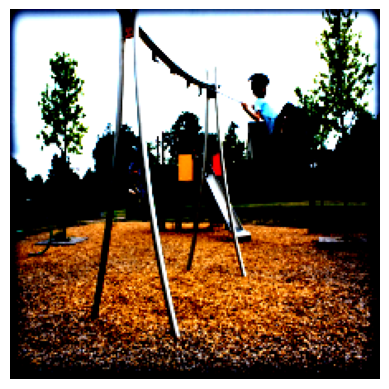

Image: 3717809376_f97611ab84.jpg
Caption: man a in shirt a on street <end>



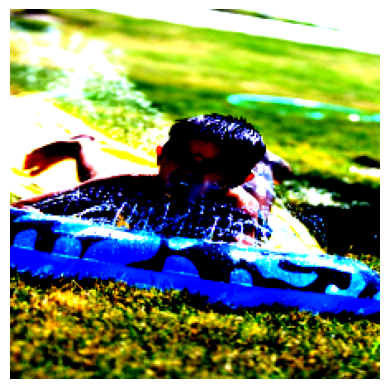

Image: 3759230208_1c2a492b12.jpg
Caption: man a in shirt a on street <end>



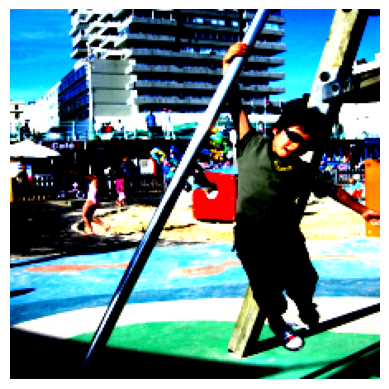

Image: 3759492488_592cd78ed1.jpg
Caption: man a in shirt a on street <end>



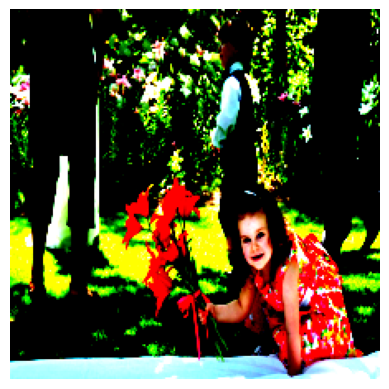

Image: 3760400645_3ba51d27f9.jpg
Caption: man a in shirt a on street <end>



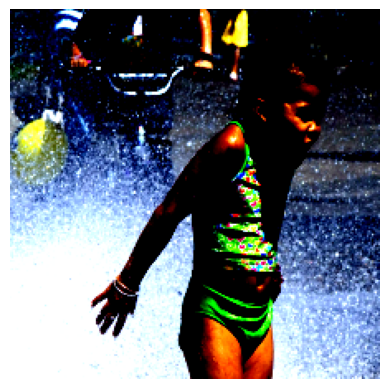

Image: 3765374230_cb1bbee0cb.jpg
Caption: man a in shirt a on street <end>



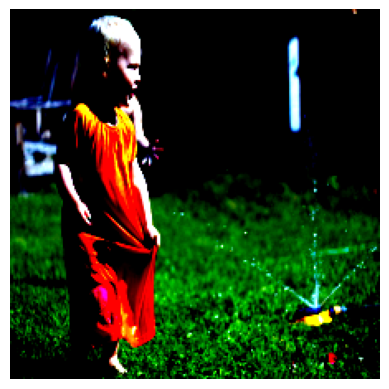

Image: 3767841911_6678052eb6.jpg
Caption: man a in shirt a on street <end>



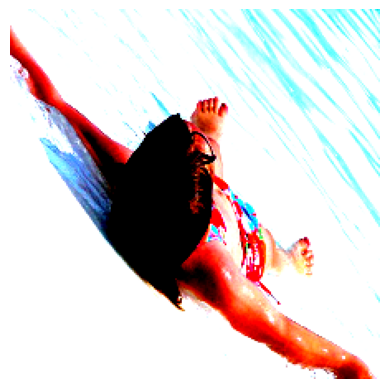

Image: 667626_18933d713e.jpg
Caption: man a in shirt a on street <end>



In [38]:
#  test the model on a few images
import os
import matplotlib.pyplot as plt
from PIL import Image

for file_name in os.listdir(TEST_IMAGES_PATH)[:20]:
    # Load image
    img_path = f"{TEST_IMAGES_PATH}/{file_name}"
    image = Image.open(img_path).convert("RGB")

    image = transform(image)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    
    caption = generate_caption(image, encoder, decoder, vocab)
    print(f"Image: {file_name}\nCaption: {caption}\n")
